In [36]:
# -*- coding: utf-8 -*-
"""
Projeto Final - Processamento de Imagens
Extração de Características: Hu Moments
Classificador: Support Vector Machine (SVM)
Dataset: Coffee Bean Dataset (224x224)
Ambiente: Google Colab (Jupyter Notebook)
"""

Iniciando carregamento de imagens...
Total de imagens carregadas: 1600
Classes encontradas: {np.str_('Medium'), np.str_('Green'), np.str_('Light'), np.str_('Dark')}

Shape de X_raw_images (todas as imagens): (1600, 224, 224, 3)
Shape de y_raw_labels (todos os rótulos numéricos): (1600,)
Mapeamento de classes: {np.str_('Dark'): 0, np.str_('Green'): 1, np.str_('Light'): 2, np.str_('Medium'): 3}

Convertendo imagens para escala de cinza e aplicando limiarização (Otsu)...


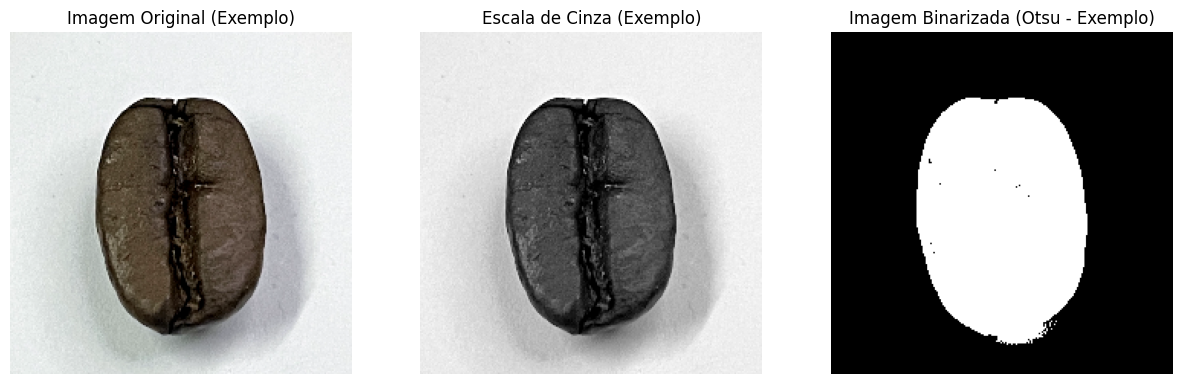

Verifique a imagem binarizada acima. Se o grão não estiver bem isolado, considere ajustar a flag do thresholding.

Extraindo Hu Moments de cada imagem binarizada...
Dimensão das características (X): (1600, 7)
Dimensão dos rótulos (y): (1600,)

Dividindo dados aleatoriamente em conjuntos de treino e teste (70/30)...
Tamanho do conjunto de treino: 1120 amostras
Tamanho do conjunto de teste: 480 amostras

Treinando o classificador SVM...
Treinamento do SVM concluído!

Avaliando o desempenho do modelo no conjunto de teste...

--- Métricas de Desempenho ---
Acurácia: 0.3375
Precisão: 0.3274
Recall: 0.3375
F1-score: 0.3097

--- Matriz de Confusão ---
[[41 21  8 50]
 [26 53  6 35]
 [31 37  7 45]
 [40 14  5 61]]


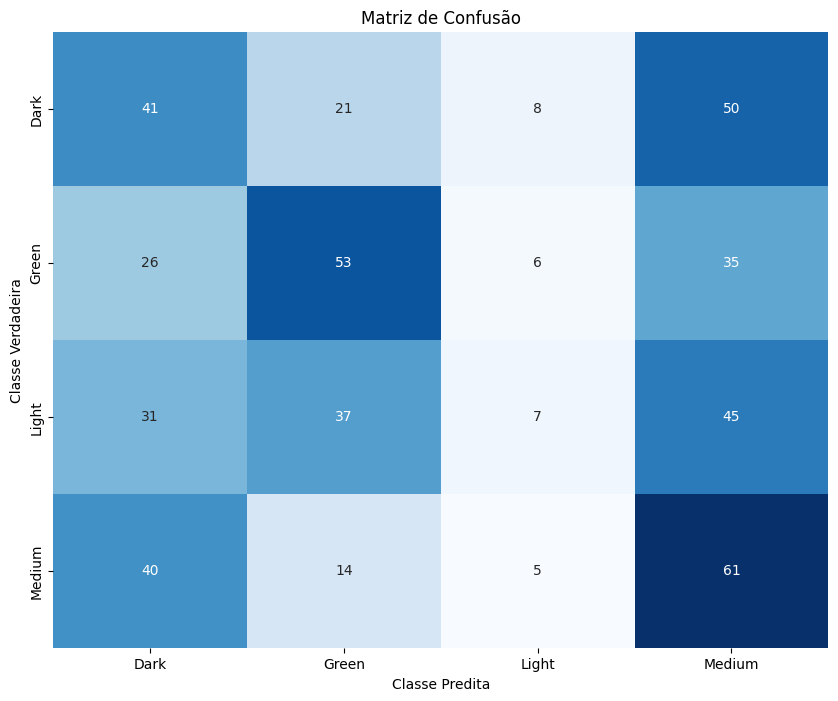


Projeto Finalizado com Sucesso!


In [61]:

"""
Projeto Final - Processamento de Imagens
"""

import cv2
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

def carregar_imagens(pasta_base):
    imagens = []
    labels = []
    for pasta_tipo in ['train', 'test']:
        caminho_pasta_tipo = os.path.join(pasta_base, pasta_tipo)
        if not os.path.exists(caminho_pasta_tipo):
            print(f"Aviso: Pasta não encontrada: {caminho_pasta_tipo}")
            continue
        for classe in os.listdir(caminho_pasta_tipo):
            caminho_classe = os.path.join(caminho_pasta_tipo, classe)
            if os.path.isdir(caminho_classe):
                for arquivo in os.listdir(caminho_classe):
                    if arquivo.lower().endswith(('.png', '.jpg', '.jpeg')):
                        caminho_arquivo = os.path.join(caminho_classe, arquivo)
                        try:
                            img = Image.open(caminho_arquivo).convert('RGB')
                            img_np = np.array(img)
                            img_cv2 = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)
                            img_resized = cv2.resize(img_cv2, (224, 224))
                            imagens.append(img_resized)
                            labels.append(classe)
                        except Exception as e:
                            print(f"Aviso: Erro ao carregar ou processar {caminho_arquivo}: {e}")
    return np.array(imagens), np.array(labels)

pasta_base = "../resource/database/coffe-beans"

print("Iniciando carregamento de imagens...")
try:
    X_raw_images, y_raw_labels_str = carregar_imagens(pasta_base)
    print(f'Total de imagens carregadas: {len(X_raw_images)}')
    print(f'Classes encontradas: {set(y_raw_labels_str)}')

    if len(X_raw_images) == 0:
        print("ERRO: Nenhuma imagem foi carregada. Verifique o 'pasta_base' e a estrutura de pastas.")
        exit()

except Exception as e:
    print(f"ERRO CRÍTICO no carregamento de imagens: {e}")
    print("Verifique o caminho base do dataset e as permissões de acesso aos arquivos.")
    exit()

class_names = sorted(list(set(y_raw_labels_str)))
label_to_index = {name: i for i, name in enumerate(class_names)}
y_raw_labels = np.array([label_to_index[label_str] for label_str in y_raw_labels_str])

print(f"\nShape de X_raw_images (todas as imagens): {X_raw_images.shape}")
print(f"Shape de y_raw_labels (todos os rótulos numéricos): {y_raw_labels.shape}")
print(f"Mapeamento de classes: {label_to_index}")

print("\nConvertendo imagens para escala de cinza e aplicando limiarização (Otsu)...")
gray_images = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in X_raw_images]

binary_images = []
for i, gray_img in enumerate(gray_images):
    _, binary = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    binary_images.append(binary)

    if i == 0:
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(cv2.cvtColor(X_raw_images[0], cv2.COLOR_BGR2RGB))
        plt.title('Imagem Original (Exemplo)')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(gray_img, cmap='gray')
        plt.title('Escala de Cinza (Exemplo)')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(binary, cmap='gray')
        plt.title('Imagem Binarizada (Otsu - Exemplo)')
        plt.axis('off')
        plt.show()
        print("Verifique a imagem binarizada acima. Se o grão não estiver bem isolado, considere ajustar a flag do thresholding.")

print("\nExtraindo Hu Moments de cada imagem binarizada...")
hu_moments_features = []
for binary_img in binary_images:
    moments = cv2.moments(binary_img)
    if moments['m00'] == 0:
        hu_moments = np.zeros((7, 1))
    else:
        hu_moments = cv2.HuMoments(moments)

    hu_moments_features.append((-np.sign(hu_moments) * np.log(np.abs(hu_moments) + 1e-7)).flatten())

X = np.array(hu_moments_features)
y = y_raw_labels

print(f"Dimensão das características (X): {X.shape}")
print(f"Dimensão dos rótulos (y): {y.shape}")

print("\nDividindo dados aleatoriamente em conjuntos de treino e teste (70/30)...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"Tamanho do conjunto de treino: {len(X_train)} amostras")
print(f"Tamanho do conjunto de teste: {len(X_test)} amostras")

print("\nTreinando o classificador SVM...")
classifier = SVC(kernel='linear', random_state=42)
classifier.fit(X_train, y_train)
print("Treinamento do SVM concluído!")

print("\nAvaliando o desempenho do modelo no conjunto de teste...")
y_pred = classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=1)

print("\n--- Métricas de Desempenho ---")
print(f"Acurácia: {accuracy:.4f}")
print(f"Precisão: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

conf_matrix = confusion_matrix(y_test, y_pred)
print("\n--- Matriz de Confusão ---")
print(conf_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            cbar=False)
plt.xlabel('Classe Predita')
plt.ylabel('Classe Verdadeira')
plt.title('Matriz de Confusão')
plt.show()

print("\nProjeto Finalizado com Sucesso!")

Iniciando carregamento de imagens...
Total de imagens carregadas: 1600
Classes encontradas: {np.str_('Medium'), np.str_('Green'), np.str_('Light'), np.str_('Dark')}

Shape de X_raw_images (todas as imagens): (1600, 224, 224, 3)
Shape de y_raw_labels (todos os rótulos numéricos): (1600,)
Mapeamento de classes: {np.str_('Dark'): 0, np.str_('Green'): 1, np.str_('Light'): 2, np.str_('Medium'): 3}

Convertendo imagens para escala de cinza, aplicando limiarização e morfologia...


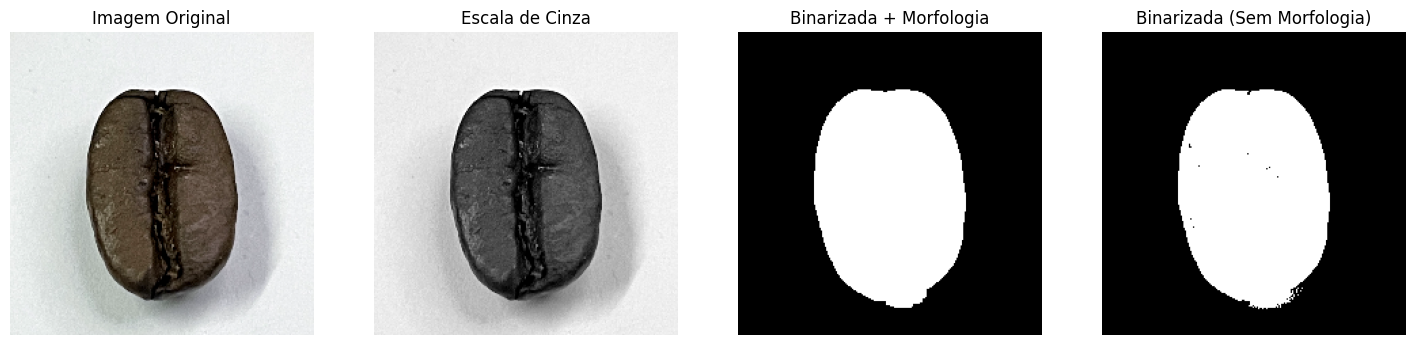

Verifique a imagem binarizada e morfológica acima. O objetivo é isolar bem o grão.

Extraindo Hu Moments de cada imagem binarizada...
Dimensão das características (X): (1600, 7)
Dimensão dos rótulos (y): (1600,)

Dividindo dados aleatoriamente em conjuntos de treino e teste (70/30)...
Tamanho do conjunto de treino: 1120 amostras
Tamanho do conjunto de teste: 480 amostras

Normalizando características (Hu Moments) usando StandardScaler...
Características normalizadas.

Treinando e otimizando o classificador SVM com GridSearchCV...
Fitting 5 folds for each of 40 candidates, totalling 200 fits


/home/jeanverso/.pyenv/versions/3.12.3/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/home/jeanverso/.pyenv/versions/3.12.3/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/home/jeanverso/.pyenv/versions/3.12.3/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refr

[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time=   0.0s
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time=   0.1s
[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time=   0.0s
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time=   0.0s
[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time=   0.0s
[CV] END ..................C

/home/jeanverso/.pyenv/versions/3.12.3/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/home/jeanverso/.pyenv/versions/3.12.3/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/home/jeanverso/.pyenv/versions/3.12.3/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refr

[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time=   0.0s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   0.1s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   0.1s
[CV] END ...................C=0.1, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ...................C=0.1, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END ...................C=0.1, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END ...................C=0.1, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END ...................C=0.1, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END ...................

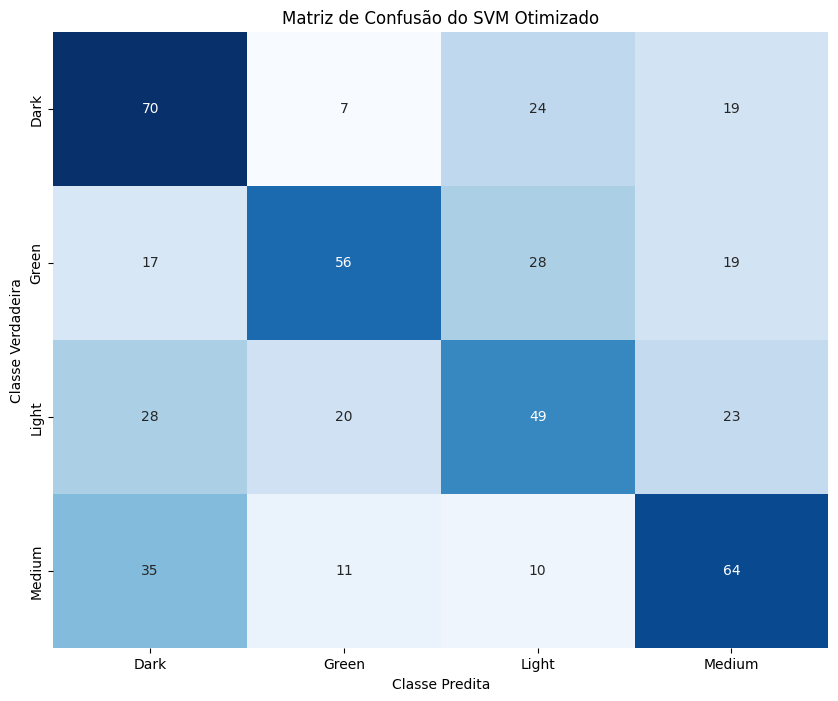


Projeto Finalizado com Sucesso!


In [62]:

"""
Projeto Final - Processamento de Imagens
"""

import cv2
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

pasta_base = "../resource/database/coffe-beans"

def carregar_imagens(pasta_base):
    imagens = []
    labels = []
    for pasta_tipo in ['train', 'test']:
        caminho_pasta_tipo = os.path.join(pasta_base, pasta_tipo)
        if not os.path.exists(caminho_pasta_tipo):
            print(f"Aviso: Pasta não encontrada: {caminho_pasta_tipo}")
            continue
        for classe in os.listdir(caminho_pasta_tipo):
            caminho_classe = os.path.join(caminho_pasta_tipo, classe)
            if os.path.isdir(caminho_classe):
                for arquivo in os.listdir(caminho_classe):
                    if arquivo.lower().endswith(('.png', '.jpg', '.jpeg')):
                        caminho_arquivo = os.path.join(caminho_classe, arquivo)
                        try:
                            img = Image.open(caminho_arquivo).convert('RGB')
                            img_np = np.array(img)
                            img_cv2 = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)
                            img_resized = cv2.resize(img_cv2, (224, 224))
                            imagens.append(img_resized)
                            labels.append(classe)
                        except Exception as e:
                            print(f"Aviso: Erro ao carregar ou processar {caminho_arquivo}: {e}")
    return np.array(imagens), np.array(labels)

print("Iniciando carregamento de imagens...")
try:
    X_raw_images, y_raw_labels_str = carregar_imagens(pasta_base)
    print(f'Total de imagens carregadas: {len(X_raw_images)}')
    print(f'Classes encontradas: {set(y_raw_labels_str)}')

    if len(X_raw_images) == 0:
        print("ERRO: Nenhuma imagem foi carregada. Verifique o 'pasta_base' e a estrutura de pastas.")
        exit()

except Exception as e:
    print(f"ERRO CRÍTICO no carregamento de imagens: {e}")
    print("Verifique o caminho base do dataset e as permissões de acesso aos arquivos.")
    exit()

class_names = sorted(list(set(y_raw_labels_str)))
label_to_index = {name: i for i, name in enumerate(class_names)}
y_raw_labels = np.array([label_to_index[label_str] for label_str in y_raw_labels_str])

print(f"\nShape de X_raw_images (todas as imagens): {X_raw_images.shape}")
print(f"Shape de y_raw_labels (todos os rótulos numéricos): {y_raw_labels.shape}")
print(f"Mapeamento de classes: {label_to_index}")

print("\nConvertendo imagens para escala de cinza, aplicando limiarização e morfologia...")
gray_images = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in X_raw_images]

binary_images = []
for i, gray_img in enumerate(gray_images):
    _, binary = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    kernel = np.ones((3,3), np.uint8)
    binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=1)
    binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations=1)
    binary_images.append(binary)

    if i == 0:
        plt.figure(figsize=(18, 6))
        plt.subplot(1, 4, 1)
        plt.imshow(cv2.cvtColor(X_raw_images[0], cv2.COLOR_BGR2RGB))
        plt.title('Imagem Original')
        plt.axis('off')

        plt.subplot(1, 4, 2)
        plt.imshow(gray_img, cmap='gray')
        plt.title('Escala de Cinza')
        plt.axis('off')

        plt.subplot(1, 4, 3)
        plt.imshow(binary_images[0], cmap='gray')
        plt.title('Binarizada + Morfologia')
        plt.axis('off')

        _, raw_binary = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        plt.subplot(1, 4, 4)
        plt.imshow(raw_binary, cmap='gray')
        plt.title('Binarizada (Sem Morfologia)')
        plt.axis('off')

        plt.show()
        print("Verifique a imagem binarizada e morfológica acima. O objetivo é isolar bem o grão.")

print("\nExtraindo Hu Moments de cada imagem binarizada...")
hu_moments_features = []
for binary_img in binary_images:
    moments = cv2.moments(binary_img)
    if moments['m00'] == 0:
        hu_moments = np.zeros((7, 1))
    else:
        hu_moments = cv2.HuMoments(moments)
    hu_moments_features.append((-np.sign(hu_moments) * np.log(np.abs(hu_moments) + 1e-7)).flatten())

X = np.array(hu_moments_features)
y = y_raw_labels

print(f"Dimensão das características (X): {X.shape}")
print(f"Dimensão dos rótulos (y): {y.shape}")

print("\nDividindo dados aleatoriamente em conjuntos de treino e teste (70/30)...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"Tamanho do conjunto de treino: {len(X_train)} amostras")
print(f"Tamanho do conjunto de teste: {len(X_test)} amostras")

print("\nNormalizando características (Hu Moments) usando StandardScaler...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Características normalizadas.")
print("\nTreinando e otimizando o classificador SVM com GridSearchCV...")

param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.01, 0.1, 1],
    'kernel': ['rbf', 'linear']
}

svm_model = SVC(random_state=42, class_weight='balanced')

grid_search = GridSearchCV(svm_model, param_grid, cv=5, verbose=2, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

print("\nGridSearchCV concluído.")
print(f"Melhores hiperparâmetros encontrados: {grid_search.best_params_}")
print(f"Melhor pontuação (acurácia na validação cruzada): {grid_search.best_score_:.4f}")

classifier = grid_search.best_estimator_
print("Classificador SVM otimizado pronto.")

print("\nAvaliando o desempenho do modelo otimizado no conjunto de teste...")
y_pred = classifier.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=1)

print("\n--- Métricas de Desempenho (Modelo Otimizado) ---")
print(f"Acurácia: {accuracy:.4f}")
print(f"Precisão: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

conf_matrix = confusion_matrix(y_test, y_pred)
print("\n--- Matriz de Confusão (Modelo Otimizado) ---")
print(conf_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            cbar=False)
plt.xlabel('Classe Predita')
plt.ylabel('Classe Verdadeira')
plt.title('Matriz de Confusão do SVM Otimizado')
plt.show()

print("\nProjeto Finalizado com Sucesso!")